In [1]:
# DEFINITION OF LIBRARIES
# ------------------------------------------------
import re
import os
import math
import spacy
import numpy as np
import pandas as pd
import seaborn as sb

# DEFINITION OF PROPRIETARY LIBRARIES 
# ------------------------------------------------
from py_constants import ROOT_INPUT, ROOT_OUTPUT, ROOT_TREE, OUTPUT_FILE
from py_constants import METRIC, METHOD
from py_constants import LS_TYPES, LS_GROUPS, COLUMN_NAMES
from py_constants import T1, T2, T3, T4, T5
from py_constants import C1, C2, C3
from py_machine_learning import agrupador
from py_utilities import studentsIdentifier, columnsIdentifier
from py_utilities import outputFilesIdentifier, writeHierarchicalCSV, clearOutputCSV, mkdirOutputFolder
from py_utilities import get_printador, get_printador_cab, get_migracao
from py_preprocessing import load_file, clear_dir, write_file, write_csv
from py_preprocessing import mapear_dir_raiz, read_code, write_join
from py_preprocessing import join_tasks, removeLineComment, removeBlockComment


%run PY_extrator.ipynb

In [4]:
# MAIN FUNCTION
# ------------------------------------------------
def main(classroom=C1, lista=T1, printador=False, num_clusters=4):
    
    clearOutputCSV(OUTPUT_FILE)
    # -------------------------------------------------------------------------------
    # (ls_dataset): armazena um dicionário com as features e seus valores 
    ls_dataset = []
            
    # files settings
    input_folder, output_folder, output_tree, output_cluster = outputFilesIdentifier(ROOT_INPUT, ROOT_OUTPUT, classroom, lista, ROOT_TREE)

    # create output folder if do not exist
    mkdirOutputFolder(output_folder)
            
    # join every source code solutions
    ls_todos_codigos, ls_name_files = join_tasks(input_folder, output_folder, True)

    # -------------------------------------------------------------------------------
    # OUTPUT: ls_todos_codigos: [[[cod1-joao], [cod2-joao]], [[cod1-maria], [cod2-maria]]]
    for id_aluno, (codigos_aluno, name_codes) in enumerate(zip(ls_todos_codigos, ls_name_files)):
        
        # O id de aluno inicia em 1
        id_aluno += 1
        
        features = {}             
        features = initFeatures(lista)
 
        ##-------------------------------------------------------------------------------                
        if (printador):
            get_printador_cab(id_aluno)
            print("n. of source codes: {}".format(len(codigos_aluno)))
                    
        ##-------------------------------------------------------------------------------
        ## EXTRATOR
        for id_cod, (codigo, name_code) in enumerate(zip(codigos_aluno, name_codes)):
            
            codigo = removeBlockComment(codigo)
            codigo = removeLineComment(codigo)
            
            ## Extraction of the main resources that will be used in subsequent features
            ##-------------------------------------------------------------------------------                     
            ls_signatures, ls_flags = get_signatures(codigo, LS_TYPES)
            ls_functions = get_functions(codigo, LS_TYPES)
            ls_calls = get_calls(codigo, LS_TYPES)
            ls_func_call = get_func_call(codigo, ls_flags, LS_TYPES)
            ##-------------------------------------------------------------------------------    

            features = getFeatures(features, lista, codigo, ls_calls, ls_functions, ls_func_call, LS_TYPES)
            
            if lista == T1:                 
                ls_libs = get_calls_libs(codigo, name_codes)
                if not ls_libs == "":
                    for (c, n) in zip(codigos_aluno, name_codes):
                        if ls_libs in n:
                            ls_signatures, ls_flags = get_signatures(c, LS_TYPES)
                            features['NC'] += len(get_calls(codigo, LS_TYPES))
                            break
                
        ##-------------------------------------------------------------------------------
        dict_list = {}
        dict_list.update(features)                   

        ##-------------------------------------------------------------------------------                
        if (printador):
            get_printador(dict_list)                    
     
        ls_dataset.append(dict_list)
                   
    # -------------------------------------------------------------------------------        
    # EXTRATOR        
    df = pd.DataFrame(ls_dataset)
    features_cols = df.keys()
            
    # students id (eg.: 101, 201 or 301)
    start_stud = studentsIdentifier(classroom)
            
    # get clustering
    df, dfx, c = agrupador(df, features_cols, start_stud, output_cluster, num_clusters, METRIC, METHOD, LS_GROUPS)            
    
    # columns name (eg.: NF, FLC, NP, etc)
    columns = columnsIdentifier(lista)
    print("\n>>> CONSTANT: \n{}".format(COLUMN_NAMES))
    print("\n>>> EXTRACTED FEATURES: \n{}".format(columns))
            
    # write CSV results
    writeHierarchicalCSV(df, columns, OUTPUT_FILE, dfx)
    
    return (ls_dataset)




> Folder: db-output_T1_Lista01 (ok).
0-01: ['codigoVazio.c']
1-02: ['L1EX01.c', 'L1EX02.c', 'L1EX03.c', 'L1EX04.c']
2-03: ['L1EX01.c', 'L1EX02.c', 'L1EX03.c', 'L1EX04.c', 'L1EX05.c', 'L1EX06.c', 'veiculo.c']
3-04: ['L1EX01.c', 'L1EX02.c', 'L1EX03.c', 'L1EX04.c', 'L1EX05.c', 'veiculo.c']
4-05: ['L1EX01.c', 'L1EX02.c', 'L1EX03.c', 'L1EX04.c', 'L1EX05.c', 'L1EX06.c', 'L1EX06F.c', 'veiculo.c']
5-06: ['codigoVazio.c']
6-07: ['L1EX01.c', 'L1EX02.c', 'L1EX03.c', 'L1EX04.c', 'L1EX05.c', 'L1EX06.c', 'veiculo.c']
7-08: ['L1EX01.c', 'L1EX02.c', 'L1EX03.c', 'L1EX04.c', 'L1EX05.c', 'L1EX06.c']
8-09: ['L1EX01.c', 'L1EX02.c', 'L1EX03.H', 'L1EX03.c', 'L1EX04.C']
9-10: ['L1EX01.c', 'L1EX02.c', 'L1EX03.c', 'L1EX04.c', 'L1EX05.c', 'L1EX06.c', 'veiculo.c']
10-11: ['L1EX01.C', 'L1EX02.C', 'L1EX03.C', 'L1EX04.C', 'L1EX05.C', 'L1EX06.c', 'veiculo.c']
11-12: ['L1EX01.c', 'L1EX02.c', 'L1EX03.c', 'L1EX04.c', 'L1EX05.c', 'L1EX06.c', 'veiculo.h']
12-13: ['codigoVazio.c']
13-14: ['L1EX01.c', 'L1EX02.c', 'L1EX03.c


>>> AGGLOMERATIVE HIERARCHICAL (euclidean, average)
Cophenetic Correlation Coefficient: 0.88 
[0 0 0 0 0 0 0 2 2 2 2 1 0 0 0 0 0 2 0 1 2 0 0 3 0 2 0 0 2 0 0]

>>> CONSTANT: 
{'Lista01': ['NF', 'NP', 'NC', 'NR'], 'Lista02': ['NPt_s', 'NAdd_s', 'NPt_ds', 'NAdd_ds'], 'Lista03': ['NStr', 'NStrM', 'NStrT', 'NStrI', 'NStrC'], 'Lista04': ['NFRec', 'NCRec', 'NIFPar', 'NRRec', 'NRNRec'], 'Lista05': ['NSizeof', 'NMalloc', 'NFree']}

>>> EXTRACTED FEATURES: 
['NStr', 'NStrM', 'NStrT', 'NStrI', 'NStrC', 'Cluster']

> Folder: db-output_T1_Lista04 (ok).
0-01: ['Lista recursividade exer 1.c', 'Lista recursividade exer 2.c', 'Lista recursividade exer 3.c', 'Lista recursividade exer 4.c']
1-02: ['L5EX01.c', 'L5EX02.c']
2-03: ['L5EX01.c', 'L5EX02.c', 'L5EX03.c', 'L5EX04.c']
3-04: ['L5EX01.c', 'L5EX02.c']
4-05: ['L5EX01.c', 'L5EX02.c', 'L5EX03.c', 'L5EX04.c']
5-06: ['L05EX01.C', 'L05EX02.C']
6-07: ['L5EX01.C', 'L5EX02.C', 'L5EX03.C', 'L5EX04.C']
7-08: ['L5EX1.c', 'L5EX2.c', 'L5EX3.c', 'L5EX4.c']
8-09: [

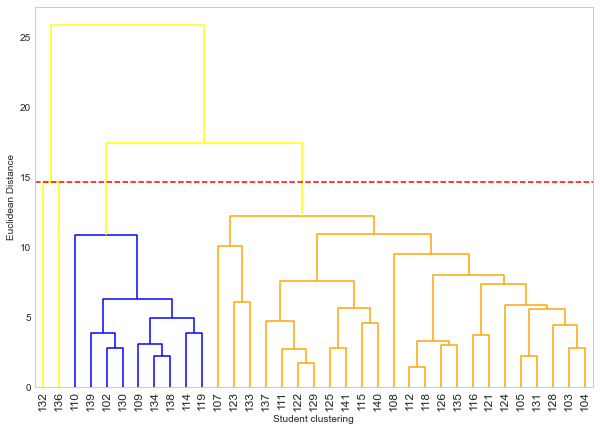

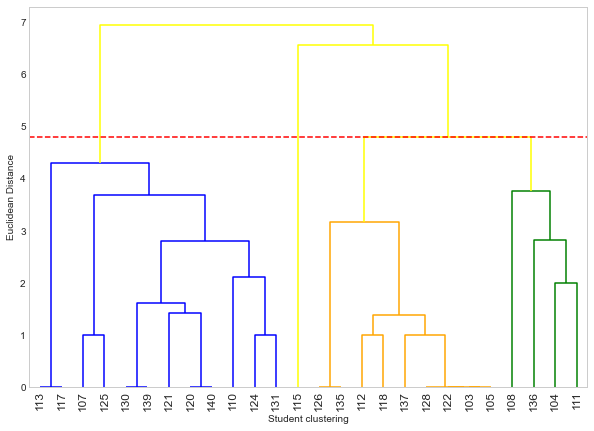

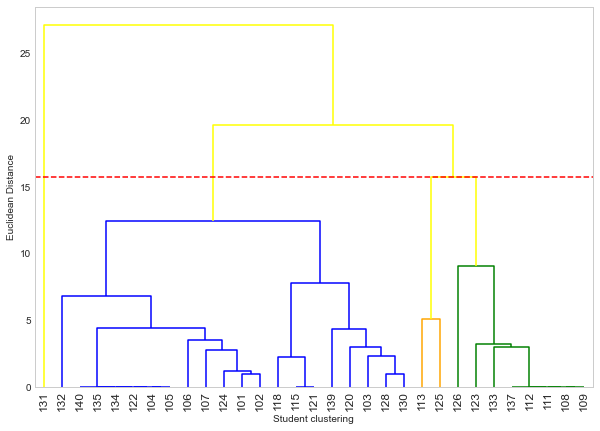

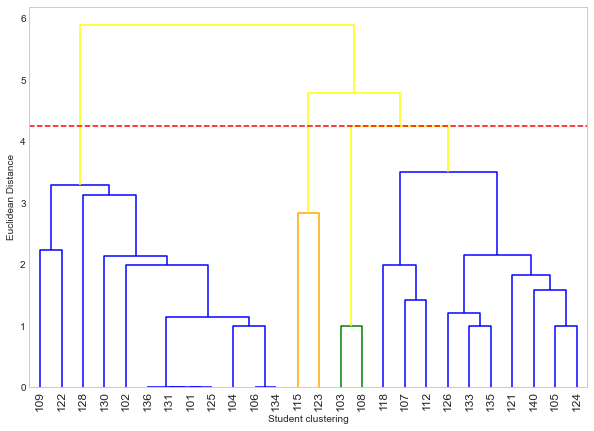

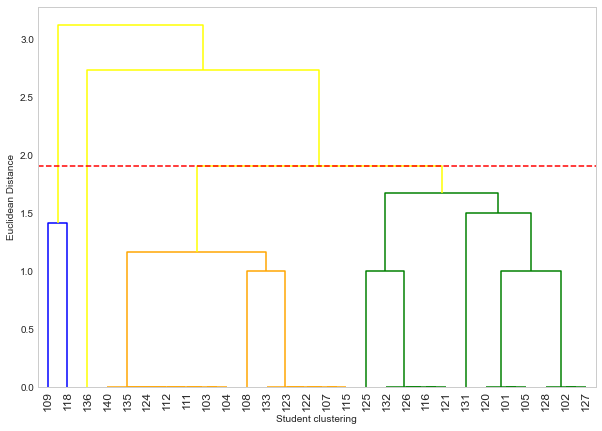

In [8]:
# SCRIPT TO RUN MULTIPLE CLASSROONS AND LISTS
# ------------------------------------------------
def scriptExec(printador=False):
    ls_turmas = {C1}
    ls_listas = {T1, T2, T3, T4, T5}
    
    for turma in sorted(ls_turmas):
        for lista in sorted(ls_listas):
            main(turma, lista, printador)
        break

# RUN MULTIPLE LISTS
# ------------------------------------------------            
scriptExec()

# RUN ONLY ONE LIST
# ------------------------------------------------  
#ls_dataset = main(C1, T1)